In [1]:
# SVM_StatQuest
# Referenced from : https://www.youtube.com/watch?v=8A7L0GsBiLQ&list=PLe6x5LUWtW6ddQiRon_vI15SGn_psxUni&index=10
# Data from : https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset

import pandas as pd # used to load and manipulate data
import numpy as np # data manipulation
import matplotlib.pyplot as plt # used for drawing graphs
import matplotlib.colors as colors # colors
from sklearn.utils import resample # downsampling the data
from sklearn.model_selection import train_test_split # used to split data into training and testing sets
from sklearn.preprocessing import scale # scale and center data
from sklearn.svm import SVC # used for support vector classifier
from sklearn.model_selection import GridSearchCV # will perform cross validation
from sklearn.metrics import confusion_matrix # used to create confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws the confusion matrix
from sklearn.decomposition import PCA # performs PCA to plot the data

df = pd.read_csv('UCI_Credit_Card.csv')
df.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [2]:
# now to change a column name to simplify calling the data

df.rename({'default.payment.next.month' : 'DEFAULT'}, axis='columns', inplace=True)


# dropping the ID column since that is not necessary for our ML model
df.drop('ID', axis=1, inplace=True)
df.head()

# in order to deal with missing data (since scikit-learn svm do not support datasets with missing values), we do the following

len(df.loc[(df['EDUCATION'] == 0) | (df['MARRIAGE'] == 0)]) # this finds how many rows contain missing values (0)

df_no_missing = df.loc[(df['EDUCATION'] != 0) & (df['MARRIAGE'] != 0)]
len(df_no_missing)
df_no_missing['MARRIAGE'].unique()

array([1, 2, 3], dtype=int64)

In [3]:
# now to start downsampling the data, since this data is large and SVM work best with smaller sample sizes
df_no_default = df_no_missing[df_no_missing['DEFAULT'] == 0]
df_default = df_no_missing[df_no_missing['DEFAULT'] == 1]

df_no_default_downsampled = resample(df_no_default, replace = False, n_samples=1000, random_state=42)

len(df_no_default_downsampled)


df_default_downsampled = resample(df_default, replace = False, n_samples=1000, random_state=42)

len(df_default_downsampled)


1000

In [4]:
# now to merge them back into a single dataframe 

df_downsample = pd.concat([df_no_default_downsampled, df_default_downsampled])
len(df_downsample)
df_downsample.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
641,130000.0,2,3,1,28,0,0,0,0,-2,...,0.0,0.0,0.0,2500.0,1000.0,0.0,0.0,0.0,0.0,0
4678,170000.0,1,3,1,29,0,0,0,0,0,...,35234.0,32869.0,33862.0,7200.0,7500.0,1200.0,1200.0,1500.0,1300.0,0
16004,180000.0,2,2,1,29,0,0,0,0,0,...,26662.0,26166.0,26176.0,1800.0,1800.0,1500.0,1056.0,950.0,1000.0,0
22974,210000.0,2,2,2,32,-2,-2,-2,-2,-2,...,0.0,0.0,0.0,979.0,412.0,0.0,0.0,0.0,0.0,0
17535,190000.0,2,3,1,45,0,0,0,0,0,...,81778.0,83082.0,84811.0,3300.0,3331.0,3359.0,2663.0,2751.0,3000.0,0


In [5]:
# now to start formatting the data to create the SVM
# this will be done by splitting the data into 2 parts : 1 part for the columns of data to make classifications
# and the second part is the column of data we want to PREDICT


X = df_downsample.drop('DEFAULT', axis=1).copy()
X.head()

# we will be utilizing one-hot encoding through the get_dummies() method from pandas

X_encoded = pd.get_dummies(X,columns = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'])

X_encoded.head()


,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7
641,130000.0,28,100143.0,50456.0,50000.0,0.0,0.0,0.0,2500.0,1000.0,...,0,1,0,0,0,0,0,0,0,0
4678,170000.0,29,165027.0,168990.0,172307.0,35234.0,32869.0,33862.0,7200.0,7500.0,...,0,0,0,1,0,0,0,0,0,0
16004,180000.0,29,25781.0,26000.0,26310.0,26662.0,26166.0,26176.0,1800.0,1800.0,...,0,0,0,1,0,0,0,0,0,0
22974,210000.0,32,355.0,975.0,410.0,0.0,0.0,0.0,979.0,412.0,...,0,1,0,0,0,0,0,0,0,0
17535,190000.0,45,76433.0,78472.0,80548.0,81778.0,83082.0,84811.0,3300.0,3331.0,...,0,0,0,1,0,0,0,0,0,0


In [6]:
# now to center and scale the data, meaning each column should have a mean = 0 and a standard deviation = 1

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42) # by default, the split is 70% train and 30% test

# scale method used to standardized dataset

X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)


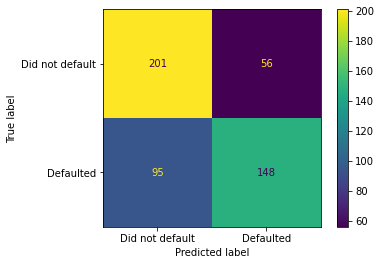

In [7]:
# now that we have finally prepared the data, we get to build a preliminary support vector machine

clf_svm = SVC(random_state=42) #sets a seed, if not specified each run of the program will provide varying results
clf_svm.fit(X_train_scaled, y_train) # fit is essentially training the svm, utilizing X_train_scaled and y_train

# now to create a confusion matrix to test the SVM's performance
# the results are : of the 257 people who did not default, only 201 were correctly identified, overall 61% which is NOT good enough

plot_confusion_matrix(clf_svm, X_test_scaled, y_test, values_format='d', display_labels=["Did not default", "Defaulted"])

In [8]:
# we will improve the SVM by utilizing cross validation using GridSearchCV()

param_grid = [{'C' : [0.5, 1, 10, 100], 'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}]

optimal_params = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=0)

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)


{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [9]:
# NOw to build, interpret the final SVM

clf_svm = SVC(random_state=42, C=100, gamma=0.001)
clf_svm.fit(X_train_scaled, y_train)

SVC(C=100, gamma=0.001, random_state=42)

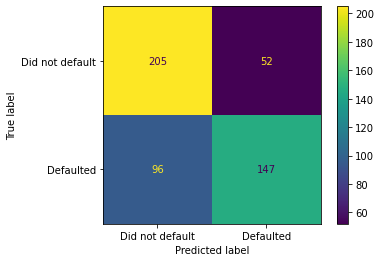

In [10]:
plot_confusion_matrix(clf_svm, X_test_scaled, y_test, values_format='d',display_labels=["Did not default", "Defaulted"])

#The results are slightly betterm, 4 more people were correctly classfied, but 1 more incorrect classification as well

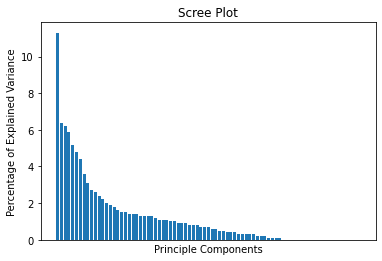

In [11]:
pca = PCA() # this centers the data, but does NOT scale it

X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_ * 100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1, len(per_var)+1), height= per_var)
plt.tick_params(axis = 'x', which='both', bottom=False, top= False, labelbottom= False)

plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principle Components')
plt.title('Scree Plot')
plt.show()

In [12]:
train_pc1_coords = X_train_pca[:, 0]
train_pc2_coords = X_train_pca[:, 1]

pca_train_scaled = scale(np.column_stack((train_pc1_coords, train_pc2_coords)))

param_grid = [{'C' : [1, 10, 100, 1000], 'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}]

optimal_params = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=0)

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


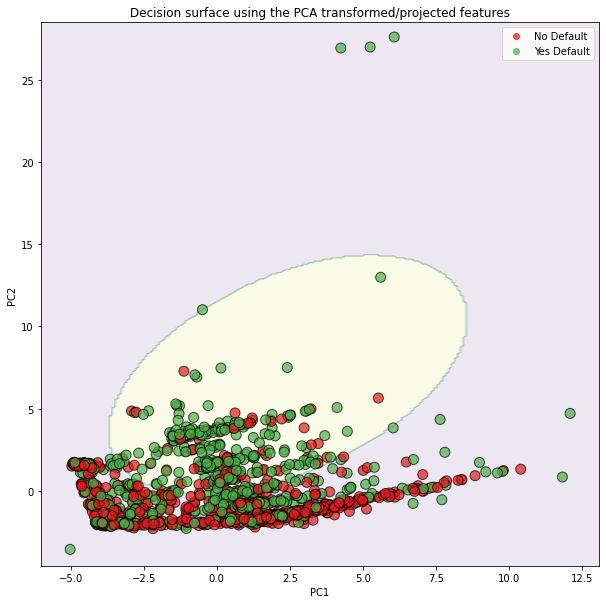

In [13]:
clf_svm = SVC(random_state=42, C=1000, gamma=0.001)
clf_svm.fit(pca_train_scaled, y_train)

X_test_pca = pca.transform(X_train_scaled)

test_pc1_coords = X_test_pca[:, 0]
test_pc2_coords = X_test_pca[:, 1]

x_min = test_pc1_coords.min() - 1
x_max = test_pc1_coords.max() + 1

y_min = test_pc2_coords.min() - 1
y_max = test_pc2_coords.max() + 1

xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1), np.arange(start=y_min, stop=y_max, step=0.1))

Z = clf_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))

Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10,10))

ax.contourf(xx, yy, Z, alpha = 0.1)

cmap = colors.ListedColormap(['#e41a1c', '#4daf4a'])

scatter = ax.scatter(test_pc1_coords, test_pc2_coords, c=y_train, cmap=cmap, s=100, edgecolors='k', alpha = 0.7)


legend = ax.legend(scatter.legend_elements()[0], scatter.legend_elements()[1], loc="upper right")

legend.get_texts()[0].set_text("No Default")
legend.get_texts()[1].set_text("Yes Default")


ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title('Decision surface using the PCA transformed/projected features')

plt.show()